<a href="https://colab.research.google.com/github/valy3124/ML-Labs/blob/main/Lab12_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-organizing map (SOM)

Self-organizing map este un algoritm de învățare nesupervizată utilizat pentru reducerea dimensionalității datelor și gruparea (clusterizarea) acestora. Menține o relație topologică între grupuri (de exemplu, regiunile similare sunt grupate aproape una de cealaltă).

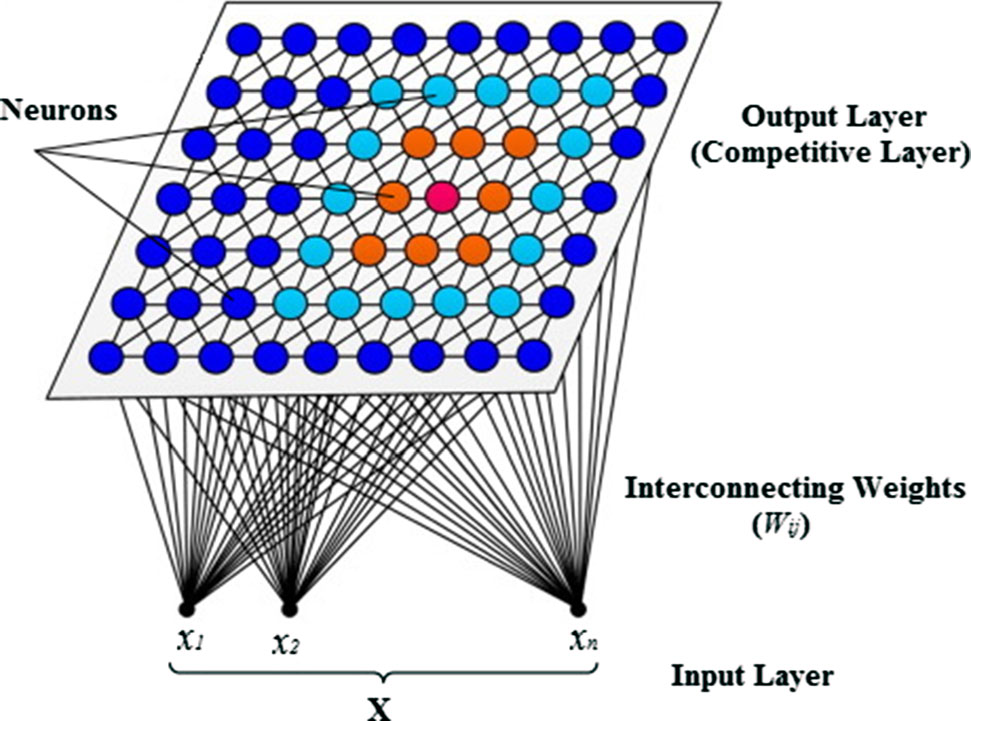


Neuronii (sau nodurile) sunt organizate într-o rețea care este de obicei 1-D sau 2-D. Toți neuronii sunt conectați complet la vectorul de intrare. Fiecare nod are o poziție topologică unică și un vector de podneri cu aceeași dimensiune ca vectorul de intrare.

În contextul comprimării imaginilor utilizând cuantizarea pe vectori, `n` reprezintă dimensiunea fiecărui bloc de imagine. Numărul de neuroni din rețea este egal cu numărul de vectori din codebook.

## Configurația SOM

În procesul de comprimare a unei imagini folosind SOM, primul pas este reprezentat de transformarea imaginii sub forma unui set de date pe care îl putem folosi pentru antrenare. În mod convențional, un dataset va fi de forma (`n_samples`, `n_features`), unde:
- `n_samples` reprezintă numărul de eșantioane
- `n_features` este dimensionalitatea unui eșantion.

<br>

### Pașii de procesare a imaginii:
1. Imaginea este împărțită în regiuni distincte (blocuri fără suprapunere) de dimensiunea (`block_height`, `block_width`). În cadrul laboratorului, valoarea implicită a blocurilor este de $4 \times 4$ pixeli.
2. Fiecare bloc este redimensionat (aplatizat/flattened) pentru a obține vectorul asociat blocului respectiv.
3. Concatenând vectorii pentru fiecare bloc, obținem datasetul folosit pentru antrenare.

Astfel, `n_samples` este egal cu numărul de blocuri din imagine, iar fiecare bloc are un număr de atribute `n_features` egal cu produsul dintre `block_height` și `block_width`.

Spre exemplu, pentru o imagine de $(512, 512)$ și `block_height` = `block_width` = 4, dimensiunea dataset-ului va fi de $(16384, 16)$.


Odată ce setul de date este creat, următorul pas constă în configurarea grid-ului SOM și determinarea razei de vecinătate pentru neuroni. Setul de ponderi din rețea (grid-ul) va fi de forma (`grid_height`, `grid_width`, `n_features`), adică un grid de neuroni de o anumită înălțime și lățime, fiecare neuron din acest grid având asociat ponderi de aceeași dimensionalitate cu datele de intrare.

### Dimensiunile grid-ului și `bits_per_codevector`

În cadrul laboratorului, dimensiunile grid-ului (înălțimea și lățimea acestuia) și raza de vecinătate sunt calculate în funcție de `bits_per_codevector`, care poate fi interpretat drept numărul de biți folosiți pentru identificarea unui vector prototip în grid-ul SOM. Practic, grid-ul va fi format din $2^{\text{bits_per_codevector}}$ neuroni, unde `grid_height` și `grid_width` sunt calculate drept două puteri ale lui 2 al căror produs să conducă la numărul dorit de neuroni.

Spre exemplu, pentru `bits_per_codevector`=3, numărul total de neuroni din grid va fi `codebook_size` = $2^3$ = 8, `grid_height`= 2 și `grid_width` = 4.

Cu cât `bits_per_codevector` este mai mare, dimensiunea grid-ului va crește împreună cu timpul de antrenare și calitatea finală a comprimării.


### Comprimarea imaginii

Ponderile învățate de SOM reprezintă blocuri prototip care comprimă informația din imaginea originală. Pentru comprimare, fiecare bloc al imaginii inițiale este înlocuit cu cel mai apropiat bloc prototip din grid-ul SOM, identificat prin neuronul corespunzător (Best Matching Unit - BMU). În acest fel, imaginea poate fi stocată sub forma grid-ului SOM învățat și a indicilor neuronilor (în locul blocurilor inițiale).

In [1]:
from typing import Dict, Union, Tuple, Optional
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Funcții ajutătoare

In [2]:
def show(image: np.ndarray, title: Optional[str] = None) -> None:
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')

    if title is not None:
        plt.title(title, fontsize=14)

    plt.axis('off')
    plt.show()

In [3]:
def get_som_config(
    image: np.ndarray,
    bits_per_codevector: int,
    block_height: int = 4,
    block_width: int = 4,
) -> Dict[str, Union[int, float, np.ndarray]]:
    """
    Generate the SOM configuration based on given image data

    :param image: The image data of shape (height, width).
    :param bits_per_codevector: Determines the size of the SOM codebook.
                                The codebook consists of a set of prototype vectors (neurons)
                                that represent the input data in a compressed form.
                                Codebook size = 2 ** bits_per_codevector.
    :param block_height: The height of each block used to create an input vector.
    :param block_width: The width of each block used to create an input vector.

    :return: A dictionary containing the entire SOM configuration
    """
    vector_dimension = block_height * block_width
    image_height, image_width = image.shape
    image_vectors = []

    # Divide the image into non-overlapping blocks and reshape into vectors
    for i in range(0, image_height, block_height):
        for j in range(0, image_width, block_width):

            # Extract the current block
            current_block = image[i:i+block_width, j:j+block_width]

            # Flatten the current block into a vector
            image_vectors.append(np.reshape(current_block, vector_dimension))

    data = np.array(image_vectors)

    codebook_size = 2 ** bits_per_codevector
    grid_height = int(2 ** np.floor(np.log2(np.sqrt(codebook_size))))
    grid_width = int(codebook_size / grid_height)
    radius = max(grid_height, grid_width) / 2

    return {
        'data': data,                   # Image vectors
        'codebook_size': codebook_size, # Number of neurons in the SOM grid
        'image_height': image_height,   # Height of the input image
        'image_width': image_width,     # Width of the input image
        'block_height': block_height,   # Height of each image block
        'block_width': block_width,     # Width of each image block
        'grid_height': grid_height,     # SOM grid height (rows)
        'grid_width': grid_width,       # SOM grid width (columns)
        'n_samples': data.shape[0],     # Total number of vectors (blocks)
        'n_features': vector_dimension, # Dimensionality of each feature vector
        'radius': radius                # Initial neighborhood radius
    }

In [4]:
def compress_image(
    reconstruction_values: np.ndarray,
    config: Dict[str, Union[int, float, np.ndarray]]
) -> np.ndarray:
    """
    Reconstruct a compressed image using the SOM's learned weights.

    :param reconstruction_values: The SOM grid weights used for reconstruction.
    :param config: The configuration dictionary used for SOM training.

    :return: The reconstructed image as a 2D array.
    """
    data = config['data']
    image_height, image_width = config['image_height'], config['image_width']
    block_height, block_width = config['block_height'], config['block_width']

    # Find the closest SOM neuron (Best Matching Unit index) for each vector
    image_vector_idxs = np.array([
        np.argmin(np.linalg.norm(reconstruction_values - vector, axis=1))
        for vector in data
    ])

    compressed_image = np.zeros([image_height, image_width], dtype=np.uint8)

    for idx, image_vector in enumerate(data):
        # Calculate the block position in the compressed image
        start_row = int(idx / (image_width / block_width)) * block_height
        end_row = start_row + block_height

        start_col = (idx * block_width) % image_width
        end_col = start_col + block_width

        # Retrieve the reconstructed block and assign it to the corresponding position
        compressed_block = reconstruction_values[image_vector_idxs[idx]]
        compressed_block = np.reshape(compressed_block, (block_height, block_width))
        compressed_image[start_row:end_row, start_col:end_col] = compressed_block

    return compressed_image

# Tests

In [5]:
def test_decay(som):
    lr, radius = som.decay(som.n_iters)
    ref = (0., 0.)
    assert np.isclose((lr, radius), ref).all(), \
           f"Decay Test failed for last iteration: {(lr, radius)} != {ref}"
    print("Decay Test for last iteration Passed")

    lr, radius = som.decay(som.n_iters // 2)
    ref = (som.initial_lr / 2, som.initial_radius / 2)
    assert np.isclose((lr, radius), ref).all(), \
           f"Decay Test failed for middle iteration: {(lr, radius)} != {ref}"
    print("Decay Test for middle iteration Passed")

    lr, radius = som.decay(0)
    ref = (som.initial_lr, som.initial_radius)
    assert np.isclose((lr, radius), ref).all(), \
           f"Decay Test failed for first iteration: {(lr, radius)} != {ref}"
    print("Decay Test for first iteration Passed")

In [6]:
def test_find_bmu_location(som, data):
    # Create a deterministic grid of sequential values (arange)
    som.grid = np.arange(som.height * som.width * som.n_features, dtype=np.float32).reshape(
        som.height, som.width, som.n_features
    )

    bmu_location = som.find_bmu_location(data[2])
    ref = (1, 3)
    assert np.equal(bmu_location, ref).all(), f"Test 1 Failed: {bmu_location} != {ref}"
    print("Test 1 BMU Location Passed")

    bmu_location = som.find_bmu_location(som.grid[0, 1])
    ref = (0, 1)
    assert np.equal(bmu_location, ref).all(), f"Test 2 Failed: {bmu_location} != {ref}"
    print("Test 2 BMU Location Passed")

In [7]:
def test_get_influence(som):
    influence = som.get_influence(1, 2)
    ref = 0.8824969025845955
    assert np.equal(influence, ref).all(), f"Test 1 Failed: {influence} != {ref}"
    print("Test 1 Influence Passed")

    influence = som.get_influence(2, 1)
    ref = 0.1353352832366127
    assert np.equal(influence, ref).all(), f"Test 2 Failed: {influence} != {ref}"
    print("Test 2 Influence Passed")

    influence = som.get_influence(0, 1)
    ref = 1.0
    assert np.equal(influence, ref).all(), f"Test 3 Failed: {influence} != {ref}"
    print("Test 3 Influence Passed")

# Imaginea de comprimat

In [8]:
image = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)
image_height, image_width = image.shape
image.shape

(512, 512)

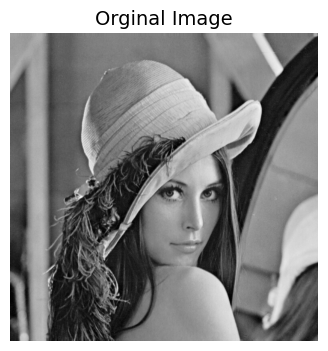

In [9]:
show(image, 'Orginal Image')

<br>
<br>
<br>

# Algoritmul SOM

### Etapele algoritmului

1. **Inițializarea ponderilor** <br>
Ponderea fiecărui nod este inițializată în funcție de tipul de date utilizat.


2. **Calcularea unității de potrivire cea mai bună - the Best Matching Unit (BMU)** <br>
Pentru un eșantion `x`, se identifică vectorul de ponderi cel mai apropiat. Neuronul corespunzător este numit neuron câștigător. De obicei, se utilizează distanța Euclidiană pentru a găsi vectorul cel mai apropiat.

<div style="font-size: 120%;">
$$
    D = \sqrt{\sum_{i=1}^n \left( x_i - w_i \right)^2}
$$
</div>


3. **Determinarea vecinătății neuronului câștigător**<br>
Acest algoritm include reducerea ariei de vecinătate în timp (pe parcursul iterațiilor). Inițial, vecinătatea cuprinde majoritatea nodurilor din rețea. În cele din urmă, vecinătatea se reduce la BMU însuși. Influența pe care distanța unui nod față de BMU o are asupra procesului de învățare este dată de:

<div style="font-size: 110%;">
$$
    \Theta(t) = \exp\left(-\frac{D^2}{2\sigma^2(t)}\right)
$$
</div>

unde `D` reprezintă distanța euclidiană dintre un nod și BMU, iar $ \sigma(t) $ este raza curentă a ariei de vecinătate.


4. **Actualizarea ponderilor**<br>
Ponderile nodurilor din vecinătatea BMU sunt actualizate conform următoarei expresii:

<div style="font-size: 120%;">
$$
    W(t+1) = W(t) + L(t) \cdot \Theta(t) \cdot \left(x(t) - W(t) \right)
$$
</div>

unde `t` reprezintă numărul iterației curente, iar $ L(t) $ este rata de învățare curentă.

Pe parcursul antrenării, atât **raza**, cât și **rata de învățare** sunt diminuate folosind spre exemplu o reducere exponențială (exponential decay) sau liniară (linear decay). Pentru acest laborator, vom folosi **reducerea liniară**.

<br>

Linear decay:
<div style="font-size: 110%;">
$$
    \sigma(t) = \sigma_0 \left( 1 - \frac{t}{T} \right) \\
    L(t) = L_0 \left( 1 - \frac{t}{T} \right)
$$
</div>

unde:
- $ t $: Iterația curentă (sau pasul de timp) în procesul de antrenare.
- $ T $: Numărul total de iterații sau timpul maxim de antrenare.
- $ \sigma_0 $: Raza inițială pentru funcția de vecinătate.
- $ L_0 $: Rata inițială de învățare.

In [13]:
class SOM:

    def __init__(
        self,
        grid_height: int,
        grid_width: int,
        n_samples: int,
        n_features: int,
        epochs: int = 3,
        lr: float = 0.7,
        radius: float = 8.,
        seed: int = 42
    ) -> None:
        """
        :param grid_height: Number of rows in the SOM grid (lattice).
        :param grid_width: Number of columns in the SOM grid (lattice).
        :param n_samples: Number of input data samples for training.
        :param n_features: Number of features (dimensions) per input sample.
        :param epochs: Number of epochs for training (default: 3).
        :param lr: Initial learning rate for weight updates (default: 0.7).
        :param radius: Initial neighborhood radius for updating neighbors (default: 8.0).
        :param seed: Random seed for reproducibility (default: 42).
        """
        self.height, self.width = grid_height, grid_width
        self.initial_radius = radius
        self.initial_lr = lr

        self.n_features = n_features
        self.n_samples = n_samples
        self.epochs = epochs
        self.seed = seed

        # Total number of iterations
        self.n_iters = self.epochs * self.n_samples
        self.initialize_grid()

    def visualize_grid(self, data: np.ndarray) -> None:
        """
        Visualize the SOM grid and the data in a 2D space.
        Handles dimensionality reduction if the data has more than 2 features.
        """
        flattened_weights = self.grid.reshape(-1, self.n_features)

        if self.n_features > 2:
            # Concatenate grid weights and data for consistent dimensionality reduction
            combined = np.vstack((flattened_weights, data))

            reducer = PCA(n_components=2, random_state=self.seed)
            reduced_combined = reducer.fit_transform(combined)

            # Separate the reduced weights and data
            reduced_weights = reduced_combined[:len(flattened_weights)]
            reduced_data = reduced_combined[len(flattened_weights):]
        else:
            # If already 2D, no dimensionality reduction needed
            reduced_weights = flattened_weights
            reduced_data = data

        # Reshape the reduced weights back into the SOM grid shape
        grid = reduced_weights.reshape(self.height, self.width, 2)

        plt.figure(figsize=(4.9, 4.1), dpi=100)
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1],
                    c='gray', alpha=0.5, label='Data', s=40)

        # Plot the SOM grid
        for x in range(self.height):
            for y in range(self.width):
                # Plot each neuron
                plt.scatter(grid[x, y, 0], grid[x, y, 1], color='blue', s=35,
                            label='Neuron' if (x == 0 and y == 0) else "")

                # Connect to neighbors (right and bottom)
                if x < self.height - 1:  # Connect to neuron below
                    plt.plot(
                        [grid[x, y, 0], grid[x + 1, y, 0]],
                        [grid[x, y, 1], grid[x + 1, y, 1]],
                        'k-', alpha=0.5
                    )
                if y < self.width - 1:  # Connect to neuron on the right
                    plt.plot(
                        [grid[x, y, 0], grid[x, y + 1, 0]],
                        [grid[x, y, 1], grid[x, y + 1, 1]],
                        'k-', alpha=0.5,
                    )

        plt.xlabel("PC1" if self.n_features > 2 else "Dim1", fontsize=12)
        plt.ylabel("PC2" if self.n_features > 2 else "Dim2", fontsize=12)
        legend = plt.legend(fontsize=12)
        legend.get_frame().set_edgecolor('0.2')
        plt.tight_layout()
        plt.show()

    def initialize_grid(self) -> None:
        """Initialize the SOM grid with random weights."""
        np.random.seed(self.seed)
        self.grid = np.random.uniform(0, 255, (self.height, self.width, self.n_features))

    def decay(self, n_iter: int) -> float:
        """
        Decay the learning rate and radius over time.

        :param n_iter: Current iteration number.
        :return: Decayed learning rate and radius.
        """
        # TODO 1: Compute the decayed versions of the
        #         learning rate and the neighborhood radius
        lr = self.initial_lr * (1 - (n_iter / self.n_iters))  # Decay the learning rate
        radius = self.initial_radius * (1 - (n_iter / self.n_iters))  # Decay the radius

        return lr, radius

    def find_bmu_location(self, sample: np.ndarray) -> tuple[int, int]:

      # Find the BMU index in the grid for a given sample

      # Compute the distances from the sample to all neurons in the grid
      # distances should be of shape (grid_height, grid_width)
      distances = np.linalg.norm(self.grid - sample, axis=2)

      # Get the index in the grid (2D coordinate) corresonding to
      # the minimum distance (np.argmin)
      bmu_location = np.unravel_index(np.argmin(distances), distances.shape)

      return bmu_location

    def get_influence(self, distance: float, radius: float) -> float:
      """
      Compute the neighborhood influence based on the distance and radius.

      :param distance: Distance from the BMU.
      :param radius: Current neighborhood radius.
      :return: Influence factor.
      """
      # Compute the influence based on distance and radius
      influence = np.exp(-distance**2 / (2 * (radius**2)))
      return influence

    def update_weights(self, lr: float, radius: float,
                   bmu_idx: tuple[int, int], sample: np.ndarray) -> None:
      """
      Update the SOM grid weights for the BMU and its neighbors.

      :param lr: Current learning rate.
      :param radius: Current neighborhood radius.
      :param bmu_idx: Location of the BMU in the grid.
      :param sample: Input vector being processed.
      """
      # Update the weights of neuron inside the radius (in the neighborhood)
      for x in range(self.height):
          for y in range(self.width):
              # Compute the distance between the coordinates
              # of the current neuron and the bmu
              distance_to_bmu = np.linalg.norm(np.array([x, y]) - np.array(bmu_idx))

              # Check if the distance is inside the radius
              if distance_to_bmu <= radius:
                  # Update the weight of the current neuron
                  influence = self.get_influence(distance_to_bmu, radius)
                  self.grid[x, y] += lr * influence * (sample - self.grid[x, y])

    def fit(self, data: np.ndarray) -> np.ndarray:
        """
        Train the SOM on the given data.

        :param data: Input data as a 2D array (n_samples, n_features).
        :return: Flattened SOM grid representing the learned prototype vectors.
        """
        n_samples, n_features = data.shape

        n_iter, lr, radius = 0, self.initial_lr, self.initial_radius
        self.initialize_grid()

        for epoch in range(self.epochs):
            for i in range(n_samples):

                # 1. Get current sample
                sample = data[i]

                # 2. Find the BMU
                bmu_idx = self.find_bmu_location(sample)

                # 3. Update weights of BMU and its neighbors
                self.update_weights(lr, radius, bmu_idx, sample)

                # 4. Decay learning rate and radius
                lr, radius = self.decay(n_iter)

                n_iter += 1

        reconstruction_values = np.reshape(self.grid, (self.height * self.width, self.n_features))
        return reconstruction_values

In [14]:
config = get_som_config(image=image, bits_per_codevector=3)  # Tests expect this config
data = config['data']

som = SOM(
    grid_height=config['grid_height'],
    grid_width=config['grid_width'],
    n_samples=config['n_samples'],
    n_features=config['n_features'],
    radius=config['radius']
)

In [15]:
test_decay(som)

Decay Test for last iteration Passed
Decay Test for middle iteration Passed
Decay Test for first iteration Passed


In [16]:
test_find_bmu_location(som, data)

Test 1 BMU Location Passed
Test 2 BMU Location Passed


In [17]:
test_get_influence(som)

Test 1 Influence Passed
Test 2 Influence Passed
Test 3 Influence Passed


In [20]:
%time reconstruction_values = som.fit(data)

CPU times: user 4.73 s, sys: 148 ms, total: 4.88 s
Wall time: 4.78 s


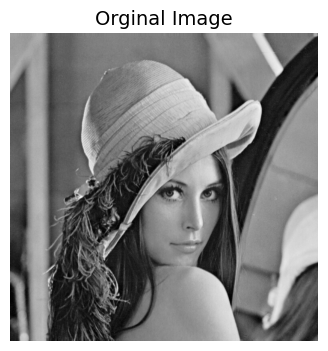

In [18]:
show(image, 'Orginal Image')

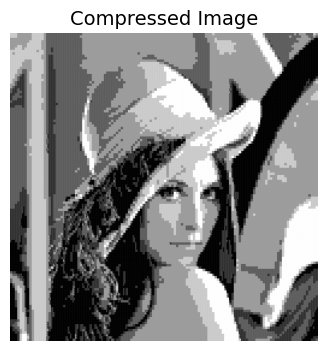

In [21]:
compressed_image = compress_image(reconstruction_values, config)
show(compressed_image, 'Compressed Image')

CPU times: user 16.1 s, sys: 43.1 ms, total: 16.2 s
Wall time: 16.5 s


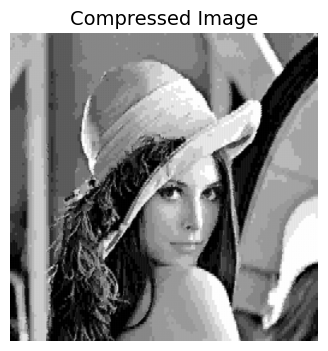

In [22]:
# Uncomment to compare with different `bits_per_codevector`

config = get_som_config(image=image, bits_per_codevector=5)
data = config['data']

som = SOM(
    grid_height=config['grid_height'],
    grid_width=config['grid_width'],
    n_samples=config['n_samples'],
    n_features=config['n_features'],
    radius=config['radius']
)

%time reconstruction_values = som.fit(data)
compressed_image = compress_image(reconstruction_values, config)
show(compressed_image, 'Compressed Image')

<br>
<br>


# Vizualizarea grid-ului SOM

In [23]:
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

In [24]:
n_samples = 500
n_features = 2
n_clusters = 6
cluster_std = [1.0, 0.8, 0.7, 1.0, 0.5, 1.1]
random_state = 40

data, labels = make_blobs(
    n_samples=n_samples, n_features=n_features, centers=n_clusters,
    cluster_std=cluster_std, random_state=random_state
)
data_min, data_max = data.min(), data.max()
data = 255 * (data - data_min) / (data_max - data_min)

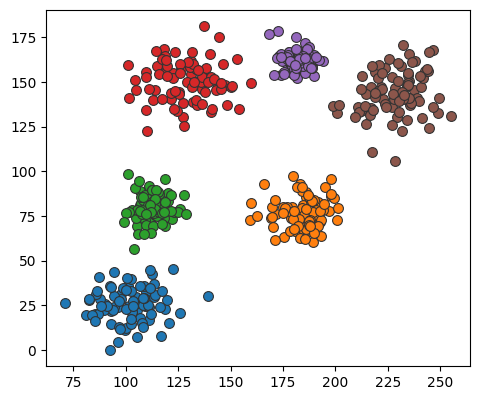

In [25]:
plt.figure(figsize=(4.9, 4.1), dpi=100)
for cluster in range(n_clusters):
    cluster_data = data[labels == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], edgecolors='0.2', lw=0.8, s=50)

plt.tight_layout()
plt.show()

In [26]:
som = SOM(grid_height=10, grid_width=10, n_samples=n_samples, n_features=n_features, radius=8.)

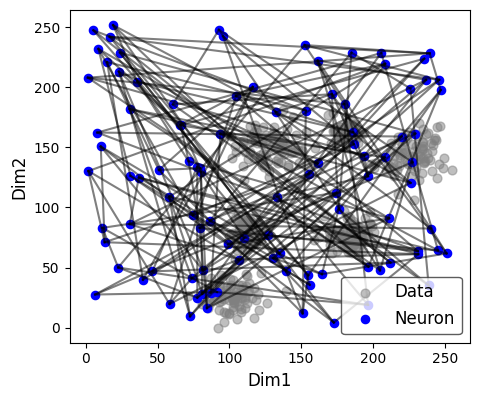

In [27]:
som.visualize_grid(data)  # Randomly initialized grid

In [28]:
%time _ = som.fit(data)

CPU times: user 1.34 s, sys: 27.6 ms, total: 1.37 s
Wall time: 1.36 s


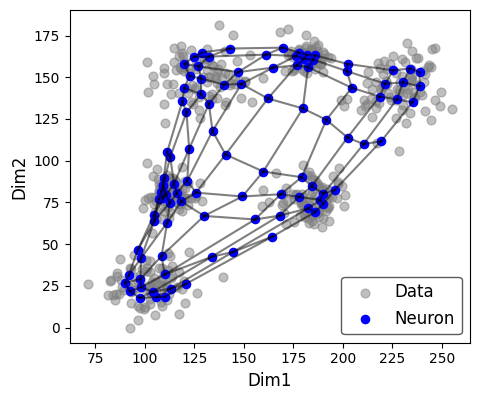

In [29]:
som.visualize_grid(data)  # The grid after training